### An Exploration of the NCAR ESM CMIP6 ScenarioMIPS Data over Chicago

A quick example of using Jupyter and xarray to interact with data from NCAR's CESM model runs submitted to the Scenerio MIPS project. Asking the question: What does the model look like over Chicago? This notebook was also written to do a quick integrety check on the data on duplication to ALCF and OLCF from LLNL.

In [1]:
import xarray as xr
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from xmovie import Movie
import pyart
import numpy as np

%matplotlib inline

/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/xmovie/core.py:23: UserWarning: Optional dependency `tqdm` not found. This will make progressbars a lot nicer.     Install with `conda install -c conda-forge tqdm`
  Install with `conda install -c conda-forge tqdm`"



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Lets look at two senarios. The two Shared Socioeconomic pathways looked at are 2, "Middle of the road" and 5, "Fossil Fuel development".

<img src='./SSP.png' width=400>

https://gmd.copernicus.org/preprints/gmd-2019-222/gmd-2019-222.pdf

We will use xarray's mfdataset to load multuple files. This is temperature "Near surface". Two meters, standard observational hieght. 

In [2]:
test_ds_tempsfcbad = xr.open_mfdataset('/eagle/projects/ESGF2/esg_dataroot/css03_data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r10i1p1f1/day/tas/gn/v20200528/tas_day_CESM2_ssp585_r10i1p1f1_gn_2*', parallel=True)
test_ds_tempsfcbetter = xr.open_mfdataset('/eagle/projects/ESGF2/esg_dataroot/css03_data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245/r10i1p1f1/day/tas/gn/v20200528/tas_day_CESM2_ssp245_r10i1p1f1_gn_2*', parallel=True)

/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/xarray/backends/plugins.py:105: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())
/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/xarray/backends/plugins.py:105: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())
/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/xarray/backends/plugins.py:105: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())
/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/xarray/backends/plugins.py:105: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())
/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-pac

Lets make sure we have the coordinates right and can extract what is happening over the Chicago area. This uses the power of xarray's coordinate awareness. 

In [3]:
center_lat = 41.8781
center_lon = 360.0 - 87.8298
window = 5.
chicago_area = test_ds_tempsfcbad.tas.sel(lat=slice(center_lat-window, center_lat + window), lon=slice(center_lon-window, center_lon+window))

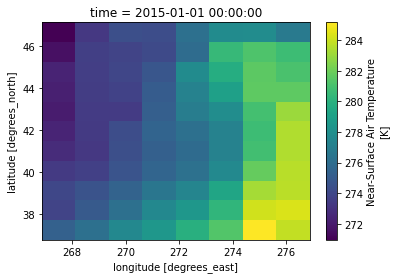

In [4]:
chicago_area.isel(time=0).plot()

Lets make a nice plot to see where the CESM grid cells are with respect to the Chicago area. This uses a lot of Cartopy's GIS power.

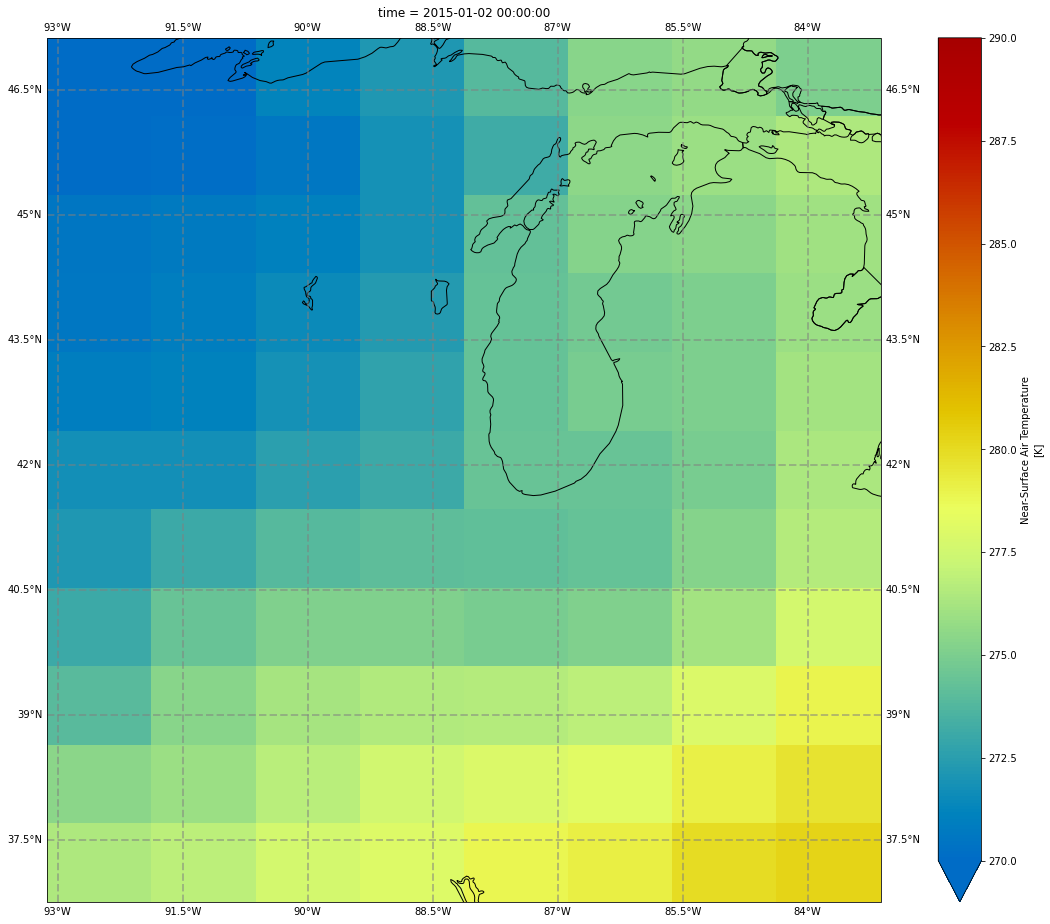

In [5]:
fig = plt.figure(figsize=[20,15])
projection = ccrs.PlateCarree()
map_panel_axes = [0.05, 0.05, .8, .80]
ax1 = fig.add_axes(map_panel_axes, projection=projection)
mp = chicago_area.isel(time=1).plot(ax=ax1,add_colorbar=True, vmin= 270., vmax = 290., cmap=pyart.graph.cm_colorblind.HomeyerRainbow) 
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAKES, facecolor='none', edgecolor='k')
#plt.colorbar(mp, cax=ax2, label='Air pressure at convective cloud base (Pa)')
gl = ax1.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ok! Looks like out coordinates are working well. Lets grab the closest grid cell to the Chicago lat/lon. Note coordinates are longitude east. We also change the index to datetimes to allow time series plotting. 

In [6]:
chicago_sfcbad = test_ds_tempsfcbad.tas.sel(lat=41.8781, lon=360.0 - 87.8298,method="nearest")
chicago_sfcbad['time'] = chicago_sfcbad.indexes['time'].to_datetimeindex()
chicago_sfcbetter = test_ds_tempsfcbetter.tas.sel(lat=41.8781, lon=360.0 - 87.8298,method="nearest")
chicago_sfcbetter['time'] = chicago_sfcbetter.indexes['time'].to_datetimeindex()

/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  
/home/scollis/.conda/envs/cmip6xarray/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


Lets plot a simple time series to see the difference between the SSP2 and SSP5 outcomes. This forces loading of the data so can take some time. 

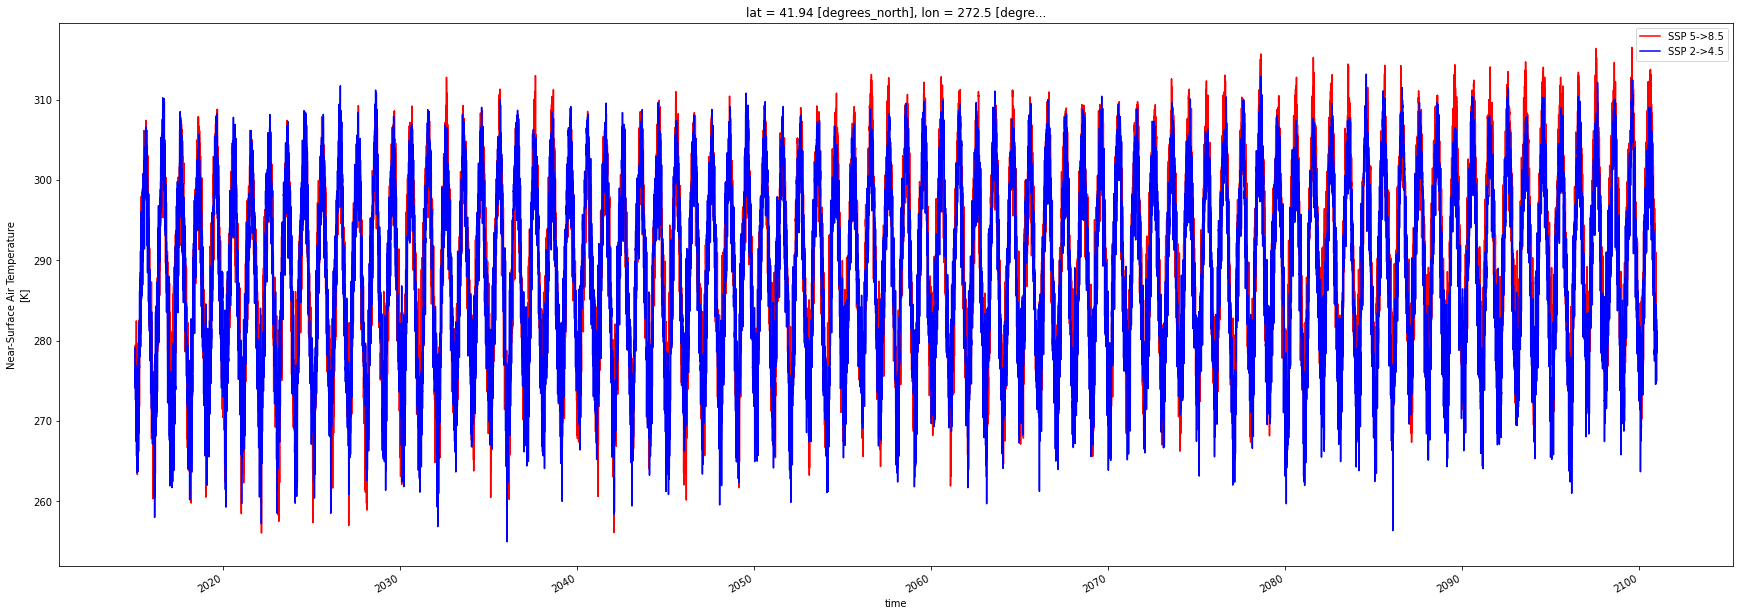

In [7]:
plt.figure(figsize=[30,10])
chicago_sfcbad.plot(color='r', label='SSP 5->8.5')
chicago_sfcbetter.plot(color='b', label='SSP 2->4.5')
plt.legend()

To get a better idea of climate change in the area lets look at a histogram of temperatures for this decade(2015-2025) to at the turn of the century (2090, 2100). And convert to celsius. 

In [8]:
this_decade_bad = chicago_sfcbad.sel(time=slice('2015 01 01', '2025 01 01')) - 273.15
future_bad = chicago_sfcbad.sel(time=slice('2090 01 01', '2100 01 01')) - 273.15

this_decade_better = chicago_sfcbetter.sel(time=slice('2015 01 01', '2025 01 01')) - 273.15
future_better = chicago_sfcbetter.sel(time=slice('2090 01 01', '2100 01 01')) - 273.15


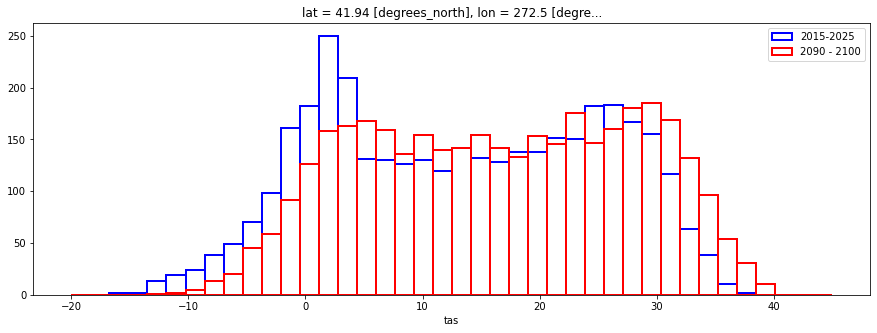

In [9]:
bins = np.linspace(-20.,45., 41)
fig = plt.figure(figsize=[15,5])
this_decade_better.plot.hist(facecolor='none', edgecolor='b', bins=bins, label='2015-2025', linewidth=2)
future_better.plot.hist(facecolor='none', edgecolor='r', bins=bins, label='2090 - 2100', linewidth=2)
plt.legend()

Ok, so somewhat worrying. You can see significant shift in temperature.. So now lets look at the much worse SSP5-8.5 scenario

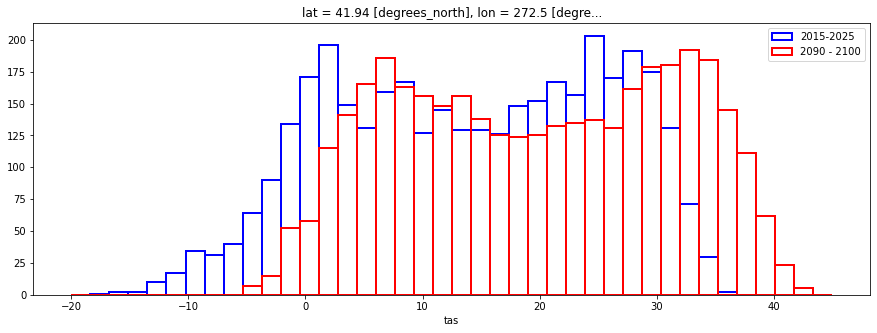

In [10]:
bins = np.linspace(-20.,45., 41)
fig = plt.figure(figsize=[15,5])
this_decade_bad.plot.hist(facecolor='none', edgecolor='b', bins=bins, label='2015-2025', linewidth=2)
future_bad.plot.hist(facecolor='none', edgecolor='r', bins=bins, label='2090 - 2100', linewidth=2)
plt.legend()

There you go.. A super simple analysis of CESM CMIP6 data over Chicago. More statistical studies to come!
